<a href="https://colab.research.google.com/github/asadian98/Deep-Learning-Course-EE25647/blob/HW3_Q2_AddLSTM_AddD/HW3/HW3_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --no-deps scikeras

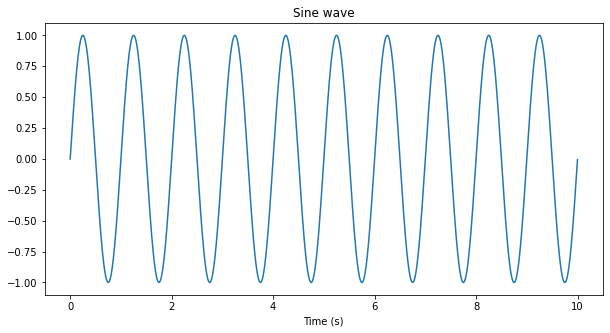

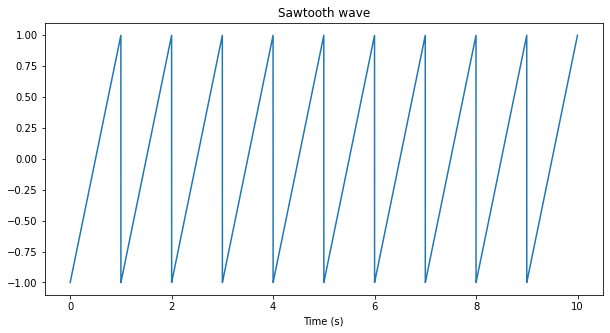

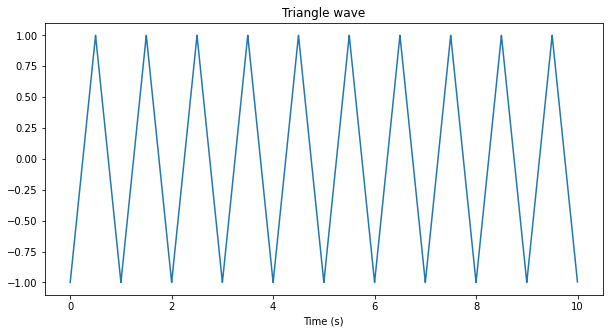

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal

t = np.arange(0, 10, 0.001)
sine_wave = np.sin(2*np.pi*t)
sawtooth_wave = signal.sawtooth(2*np.pi*t)
triangle_wave = signal.sawtooth(2*np.pi*t, 0.5)

plt.figure(figsize=(10, 5))
plt.plot(t, sine_wave)
plt.title('Sine wave')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, sawtooth_wave)
plt.title('Sawtooth wave')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, triangle_wave)
plt.title('Triangle wave')
plt.xlabel('Time (s)')
plt.show()

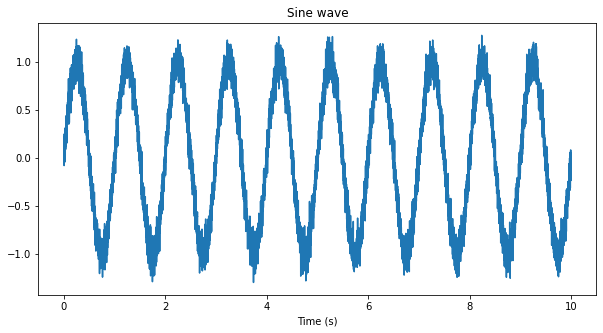

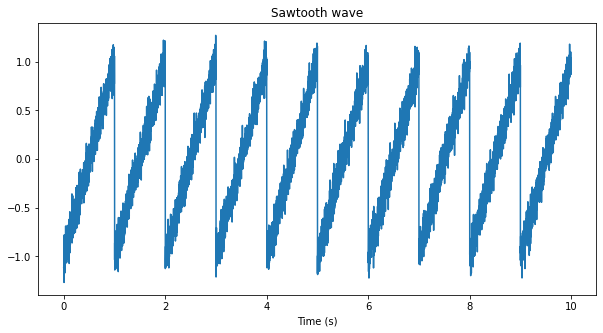

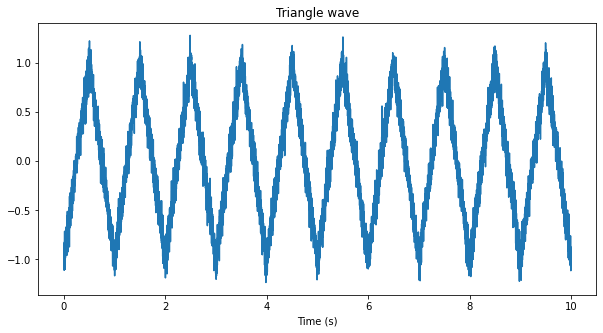

In [3]:
sine_noisy = sine_wave + np.random.normal(0,0.1,len(sine_wave))
sawtooth_noisy = sawtooth_wave + np.random.normal(0,0.1,len(sawtooth_wave))
triangle_noisy = triangle_wave + np.random.normal(0,0.1,len(triangle_wave))

plt.figure(figsize=(10, 5))
plt.plot(t, sine_noisy)
plt.title('Sine wave')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, sawtooth_noisy)
plt.title('Sawtooth wave')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, triangle_noisy)
plt.title('Triangle wave')
plt.xlabel('Time (s)')
plt.show()

In [4]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

# Prepare the input X and target Y
def get_XY(data_noisy, data, time_steps):
    rows_x = int(len(data) / time_steps)
    X = np.reshape(data_noisy, (rows_x, time_steps, 1))    
    Y = np.reshape(data, (rows_x, time_steps, 1))    
    return X, Y

def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_mse = []
    test_mse = []
    for i in range(len(trainY)):
      train_mse.append(mean_squared_error(trainY[i], train_predict[i]))
    for i in range(len(testY)):
      test_mse = math.sqrt(mean_squared_error(testY[i], test_predict[i]))
    # Print RMSE
    print('Train MSE: %.3f MSE' % (np.average(train_mse)))
    print('Test MSE: %.3f MSE' % (np.average(test_mse)))   

def plot_result(trainY, testY, train_predict, test_predict, Signal_name, std, Signal, LSTM_flag):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.plot(range(rows), Signal[0:len(predictions)], color='r')
    plt.axvline(x=len(trainY[0])*len(trainY), color='k')
    plt.legend(['Noisy', 'Denoised', 'Original'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel(Signal_name)
    if(LSTM_flag):
      plt.title('LSTM: Noisy, Denoised and Original Values for {}, standard deviation = {}. The Black Line Separates The Training And Test Examples. '.format(Signal_name, std))
    else:
      plt.title('Simple RNN: Noisy, Denoised and Original Values for {}, standard deviation = {}. The Black Line Separates The Training And Test Examples. '.format(Signal_name, std))

    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), predictions)
    plt.xlabel('Observation number after given time steps')
    plt.ylabel(Signal_name)
    plt.axvline(x=len(trainY[0])*len(trainY), color='k')
    
    if(LSTM_flag):
      plt.title('LSTM: Denoised Values for {}, standard deviation = {}. The Black Line Separates The Training And Test Examples'.format(Signal_name, std))
    else:
      plt.title('Simple RNN: Denoised Values for {}, standard deviation = {}. The Black Line Separates The Training And Test Examples'.format(Signal_name, std))

def signalPower(x):
    return np.average(x**2)

def SNRsystem(inputSig, outputSig):
    noise = np.reshape(outputSig, (len(outputSig)*len(outputSig[0]), -1))-np.reshape(inputSig, (len(inputSig)*len(inputSig[0]), -1))
    
    powS = signalPower(outputSig)
    powN = signalPower(noise)
    return 10*np.log10((powS-powN)/powN)

def LossAccPlot(history):
  plt.figure()

  plt.plot(history.history['mean_squared_error'])
  plt.plot(history.history['val_mean_squared_error'])
  plt.title('Model MSE')
  plt.ylabel('MSE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

def create_RNN(lr, LSTM_flag, num_units):
    model = Sequential()

    if(LSTM_flag):
      model.add(LSTM(num_units, input_shape=(1000,1), activation='tanh'))
    else:
      model.add(SimpleRNN(num_units, input_shape=(1000,1), activation='tanh'))

    model.add(Dense(units=1000, activation='tanh'))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics = ['mean_squared_error'])
    
    return model

def process(Signal, std, Signal_name, verbose, LSTM_flag = 0, lr = 0.001, batch_size = 1, number_of_epochs = 10, gridflag = 0, noise_time = 0):
  if(noise_time == 0):
    Signal_noisy = Signal + np.random.normal(0,std,len(Signal))
  else: 
    Signal_noisy = [Signal[((i)*1000):((i+1)*1000)] + np.random.normal(i/10, std*i,len(Signal)) for i in range(int(len(Signal)/1000))]

  train_noisy = Signal_noisy[0:int(0.7*len(Signal_noisy))]
  valid_noisy = Signal_noisy[int(0.7*len(Signal_noisy)):int(0.8*len(Signal_noisy))]
  test_noisy = Signal_noisy[int(0.8*len(Signal_noisy)):]

  train = Signal[0:int(0.7*len(Signal))]
  valid = Signal[int(0.7*len(Signal)):int(0.8*len(Signal))]
  test = Signal[int(0.8*len(Signal)):]

  time_steps = 1000
  x_train, y_train = get_XY(train_noisy, train, time_steps)
  x_valid, y_valid = get_XY(valid_noisy, valid, time_steps)
  x_test, y_test = get_XY(test_noisy, test, time_steps)
  
  if(verbose):
    model = create_RNN(lr = lr, LSTM_flag = LSTM_flag, num_units = 200)
    history = model.fit(x_train, y_train, epochs=number_of_epochs, batch_size=batch_size, validation_data = (x_valid, y_valid), verbose=1)

    # make predictions
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)

    # Mean square error
    print_error(y_train, y_test, train_predict, test_predict)

    plot_result(x_train, x_test, train_predict, test_predict, Signal_name, std, Signal, LSTM_flag)

    # Plot MSE for each epoch in training and validation
    LossAccPlot(history)

    SNR_train = SNRsystem(y_train, train_predict)
    SNR_x = SNRsystem(y_train, x_train)
    print("SNR was {}, SNR for training output: {} dB".format(SNR_x, SNR_train))
    SNR_test = SNRsystem(y_test, test_predict)
    SNR_test_x = SNRsystem(y_test, x_test)
    print("SNR was {}, SNR for training output: {} dB".format(SNR_test_x, SNR_test))

  else:
    model = KerasRegressor(model=create_RNN, LSTM_flag = 0, num_units = 100, lr=0.001, verbose=0)

    if(gridflag == 0):
      lr = [0.001, 0.01, 0.1]
      batch_size = [1]
      epochs = [10]
      num_units = [100]
    elif(gridflag == 1):
      lr = [0.001]
      batch_size = [1, 3, 5, 7]
      epochs = [10]
      num_units = [100]
    elif(gridflag == 2):
      lr = [0.001]
      batch_size = [1]
      epochs = [5, 10, 15]
      num_units = [100]

    param_grid = dict(lr=lr, batch_size=batch_size, epochs = epochs, LSTM_flag = [LSTM_flag], num_units = num_units)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring = 'neg_mean_squared_error')
    nsamples, nx, ny = x_train.shape
    x_train_g = x_train.reshape((nsamples,nx*ny))
    nsamples, nx, ny = y_train.shape
    y_train_g = y_train.reshape((nsamples,nx*ny))
    grid_result = grid.fit(x_train_g, y_train_g)

    return grid_result

### Use Simple RNN

Epoch 1/10
7/7 [==============================] - 4s 447ms/step - loss: 0.4269 - mean_squared_error: 0.4269 - val_loss: 0.2153 - val_mean_squared_error: 0.2153
Epoch 2/10
7/7 [==============================] - 3s 420ms/step - loss: 0.0964 - mean_squared_error: 0.0964 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 3/10
7/7 [==============================] - 3s 411ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 4/10
7/7 [==============================] - 3s 419ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 5/10
7/7 [==============================] - 3s 439ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 6/10
7/7 [==============================] - 3s 424ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 7/10
7/7 [========================

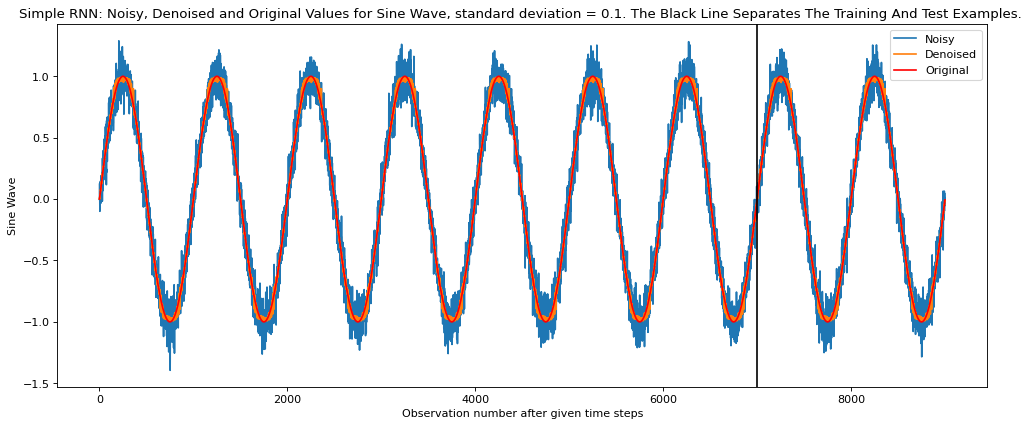

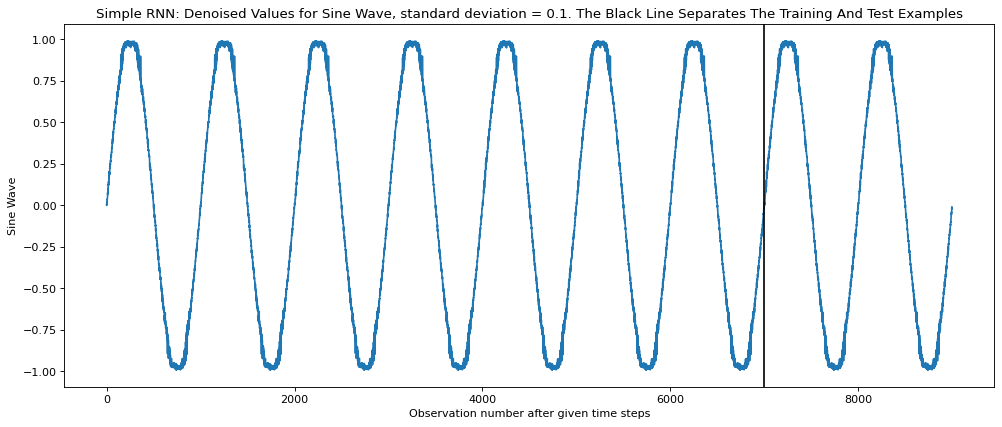

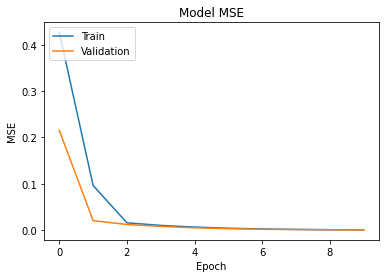

SNR was 16.972941329249863, SNR for training output: 29.679159403425892 dB
SNR was 17.203130874721303, SNR for training output: 29.68246239214323 dB


In [5]:
# Simple RNN - Sine Wave
process(sine_wave, std = 0.1, Signal_name = 'Sine Wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 0, gridflag = 0)

Epoch 1/10
7/7 [==============================] - 4s 458ms/step - loss: 0.3124 - mean_squared_error: 0.3124 - val_loss: 0.0909 - val_mean_squared_error: 0.0909
Epoch 2/10
7/7 [==============================] - 3s 422ms/step - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 3/10
7/7 [==============================] - 3s 418ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 4/10
7/7 [==============================] - 3s 420ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 5/10
7/7 [==============================] - 3s 417ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 6/10
7/7 [==============================] - 3s 412ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 7/10
7/7 [========================

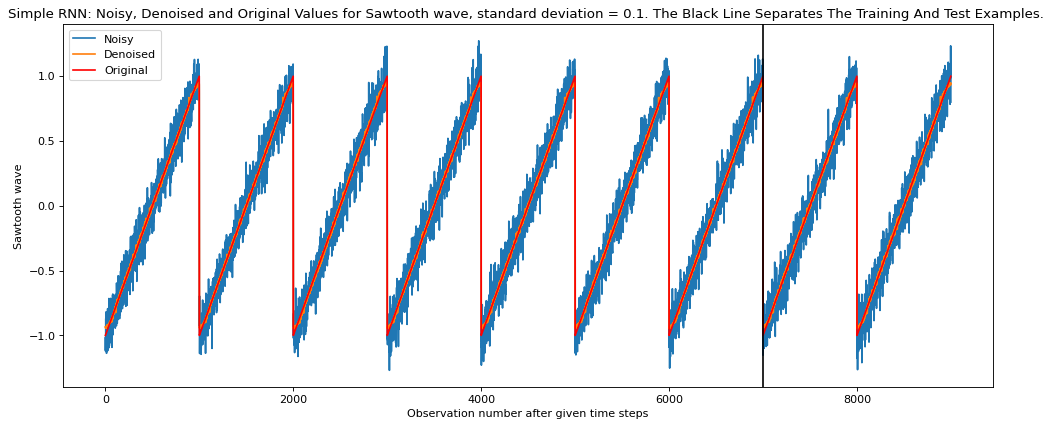

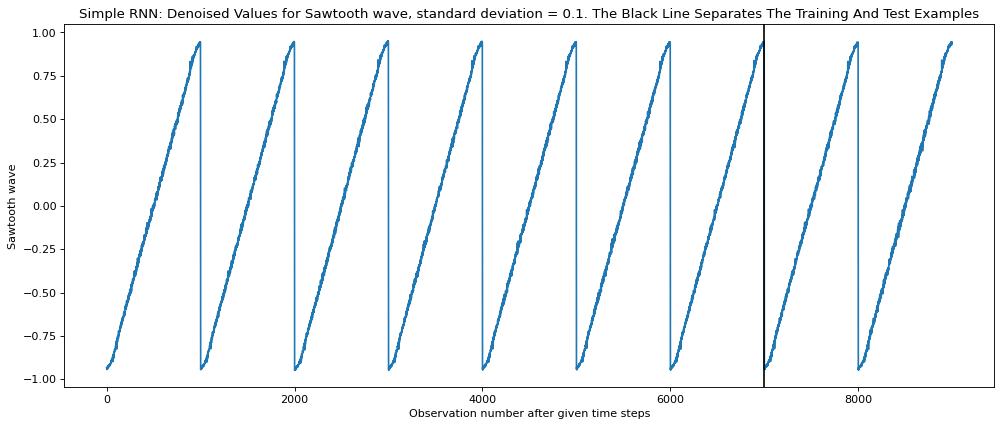

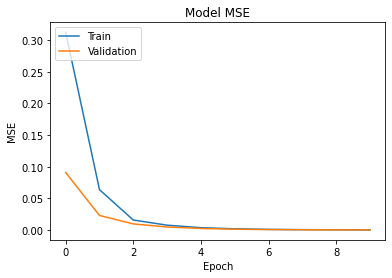

SNR was 15.243158620811855, SNR for training output: 31.7394143921552 dB
SNR was 15.354954605202856, SNR for training output: 31.11992605914577 dB


In [6]:
# Simple RNN - Sawtooth
process(sawtooth_wave, std = 0.1, Signal_name = 'Sawtooth wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 0, gridflag = 0)

Epoch 1/10
7/7 [==============================] - 4s 453ms/step - loss: 0.2252 - mean_squared_error: 0.2252 - val_loss: 0.0651 - val_mean_squared_error: 0.0651
Epoch 2/10
7/7 [==============================] - 3s 422ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 3/10
7/7 [==============================] - 3s 432ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 4/10
7/7 [==============================] - 3s 419ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 5/10
7/7 [==============================] - 3s 416ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 6/10
7/7 [==============================] - 3s 416ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 7/10
7/7 [========================

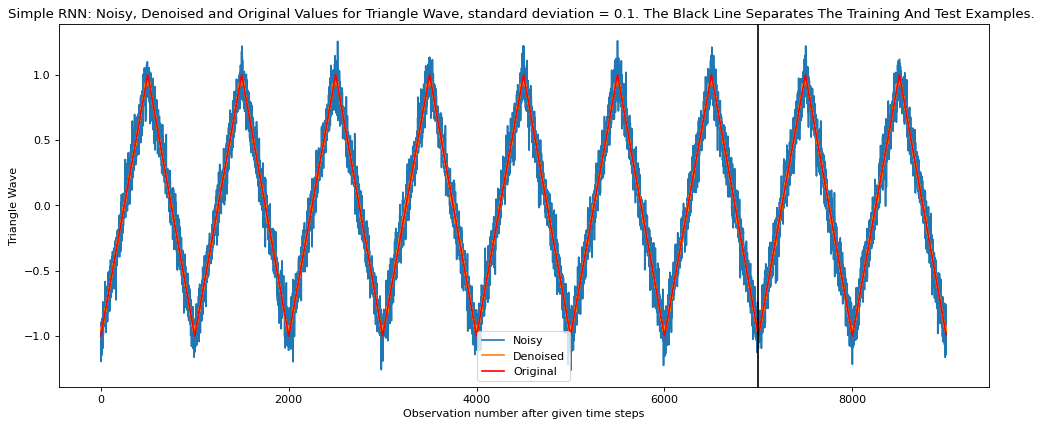

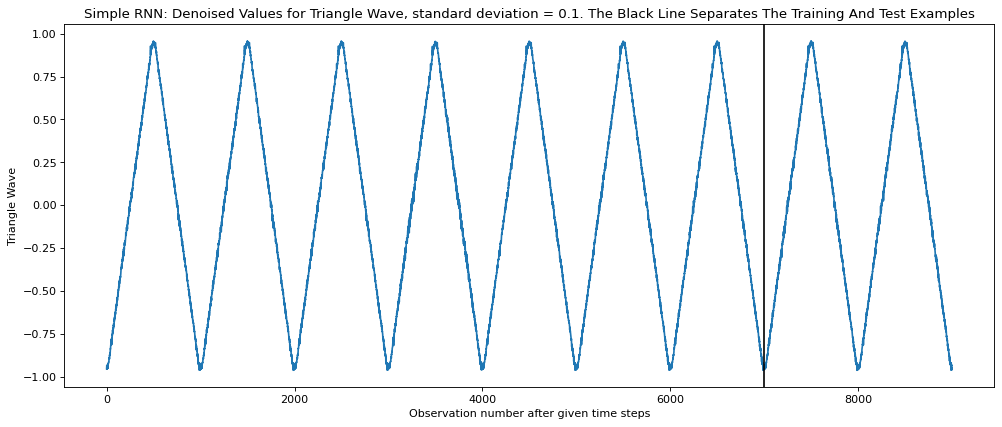

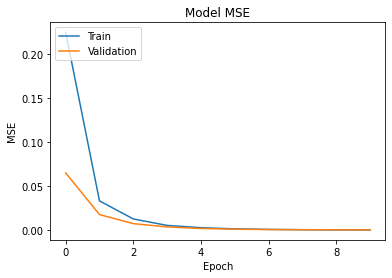

SNR was 15.19642262510761, SNR for training output: 33.18328583271405 dB
SNR was 15.104557670235511, SNR for training output: 32.89913434525043 dB


In [7]:
# Simple RNN - Triangle
process(triangle_wave, std = 0.1, Signal_name = 'Triangle Wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 0, gridflag = 0)

### Use LSTM

Epoch 1/10
7/7 [==============================] - 3s 121ms/step - loss: 0.4811 - mean_squared_error: 0.4811 - val_loss: 0.3119 - val_mean_squared_error: 0.3119
Epoch 2/10
7/7 [==============================] - 0s 53ms/step - loss: 0.1309 - mean_squared_error: 0.1309 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 3/10
7/7 [==============================] - 0s 49ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 4/10
7/7 [==============================] - 0s 52ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 5/10
7/7 [==============================] - 0s 49ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 6/10
7/7 [==============================] - 0s 48ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 7/10
7/7 [=============================

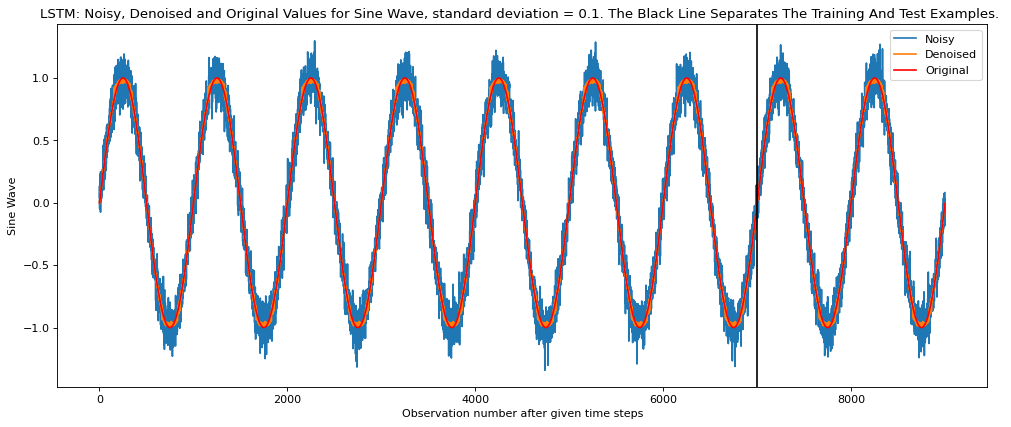

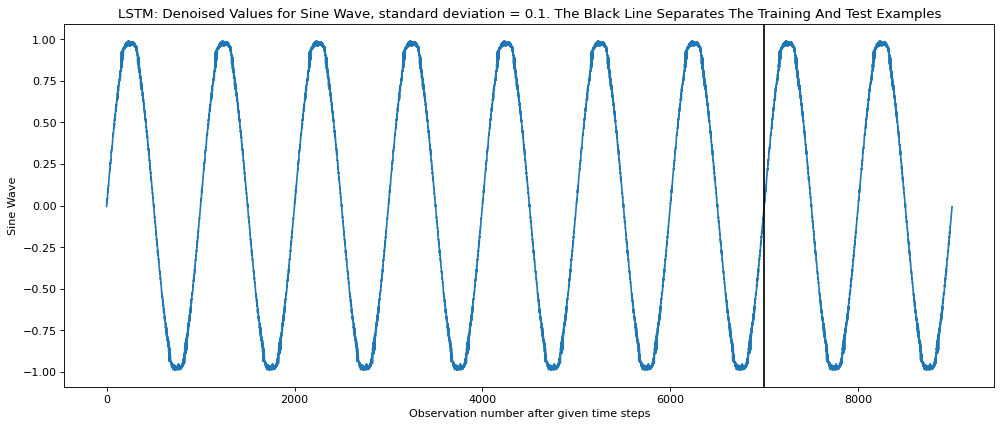

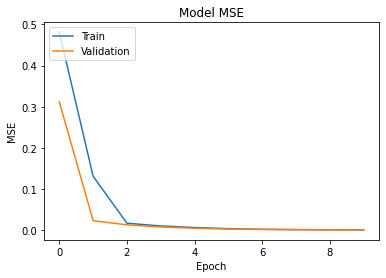

SNR was 16.97217684326575, SNR for training output: 32.06350584898169 dB
SNR was 17.012291493310453, SNR for training output: 32.06066209886937 dB


In [8]:
# LSTM - Sine Wave
process(sine_wave, std = 0.1, Signal_name = 'Sine Wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 1, gridflag = 0)

Epoch 1/10
7/7 [==============================] - 2s 120ms/step - loss: 0.2635 - mean_squared_error: 0.2635 - val_loss: 0.0847 - val_mean_squared_error: 0.0847
Epoch 2/10
7/7 [==============================] - 0s 54ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.5206 - val_mean_squared_error: 0.5206
Epoch 3/10
7/7 [==============================] - 0s 52ms/step - loss: 0.0770 - mean_squared_error: 0.0770 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 4/10
7/7 [==============================] - 0s 51ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 5/10
7/7 [==============================] - 0s 51ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 6/10
7/7 [==============================] - 0s 50ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 7/10
7/7 [=============================

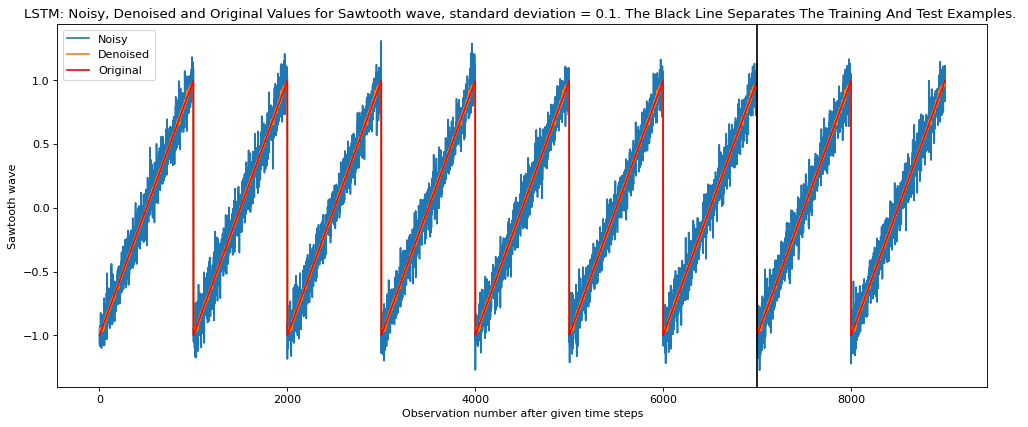

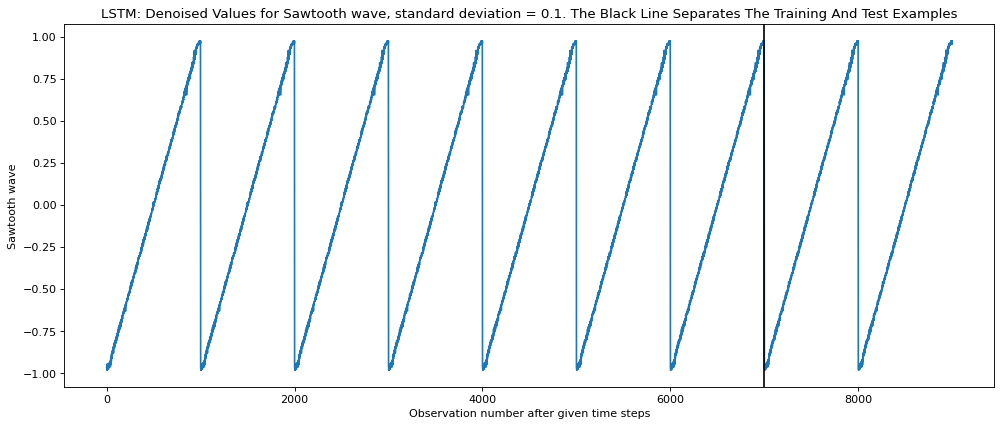

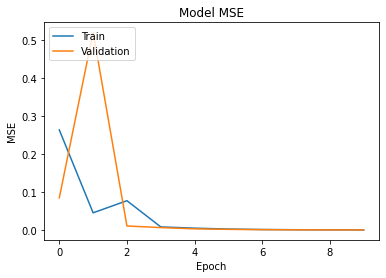

SNR was 15.274711696878644, SNR for training output: 34.44647284375149 dB
SNR was 15.084746564866123, SNR for training output: 34.51711127593261 dB


In [9]:
# LSTM - Sawtooth
process(sawtooth_wave, std = 0.1, Signal_name = 'Sawtooth wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 1, gridflag = 0)

Epoch 1/10
7/7 [==============================] - 2s 127ms/step - loss: 0.2809 - mean_squared_error: 0.2809 - val_loss: 0.1063 - val_mean_squared_error: 0.1063
Epoch 2/10
7/7 [==============================] - 0s 54ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - val_loss: 0.0158 - val_mean_squared_error: 0.0158
Epoch 3/10
7/7 [==============================] - 0s 52ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 4/10
7/7 [==============================] - 0s 51ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 5/10
7/7 [==============================] - 0s 51ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 6/10
7/7 [==============================] - 0s 51ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 8.2601e-04 - val_mean_squared_error: 8.2601e-04
Epoch 7/10
7/7 [=====================

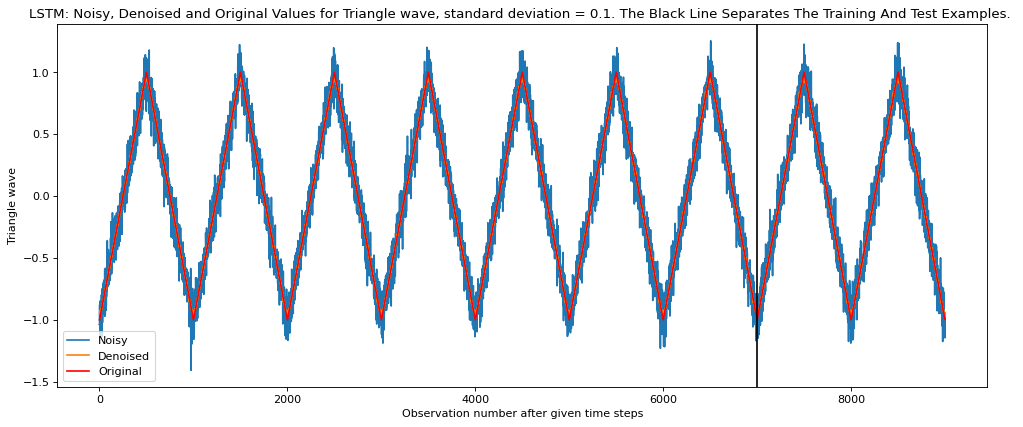

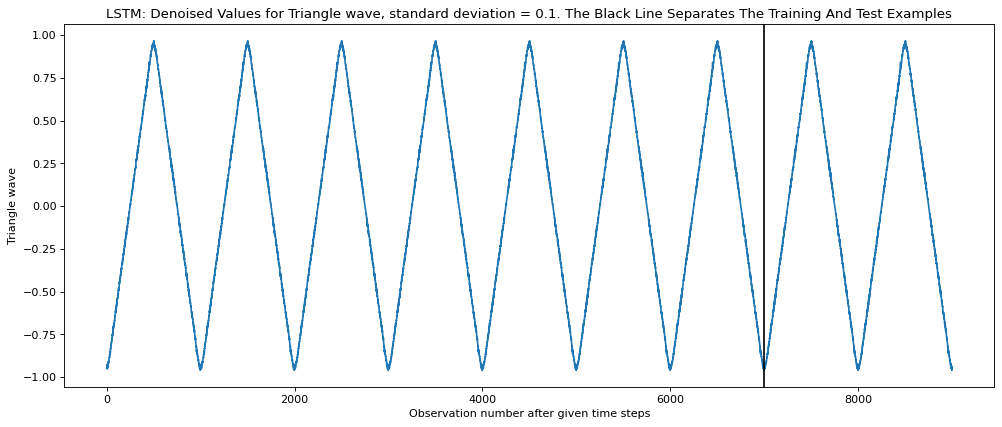

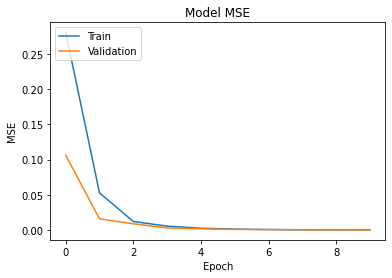

SNR was 15.228039776769862, SNR for training output: 35.055392091880826 dB
SNR was 15.213935516546773, SNR for training output: 35.04743326127893 dB


In [10]:
# LSTM - Triangle
process(triangle_wave, std = 0.1, Signal_name = 'Triangle wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 1, gridflag = 0)

### Change Learning rate, batch size and number of epochs

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.01339732 -0.17167704         nan         nan]
  category=UserWarning,


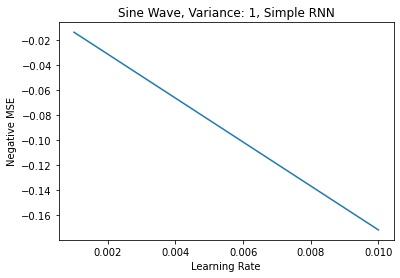

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.0025961  -0.08856403         nan         nan]
  category=UserWarning,


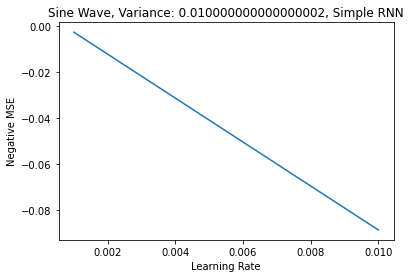

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.00247645 -0.00921961 -0.25314435         nan]
  category=UserWarning,


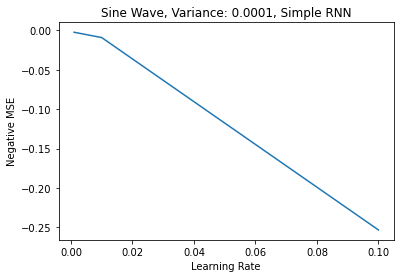

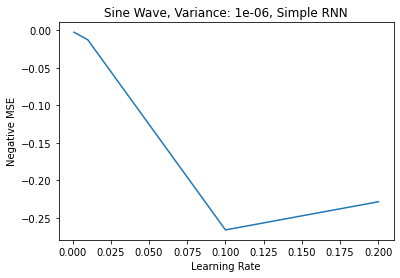

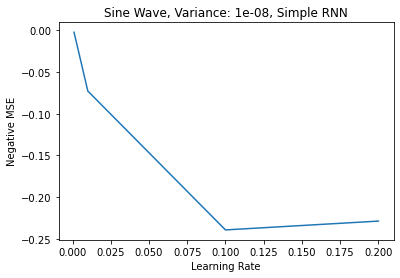

In [12]:
for std in [1, 0.1, 0.01, 0.001, 0.0001]:
  grid_result = process(sine_wave, std = std, Signal_name = 'Sine Wave', verbose = False, LSTM_flag = 0, gridflag = 0)

  plt.figure()
  plt.plot([0.001, 0.01, 0.1, 0.2], grid_result.cv_results_['mean_test_score'], )
  plt.title('Sine Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('Negative MSE')
  plt.show()

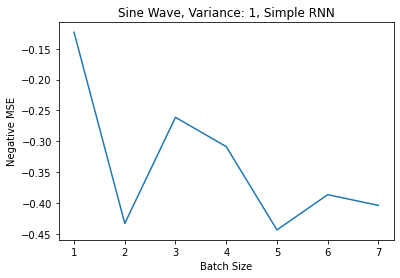

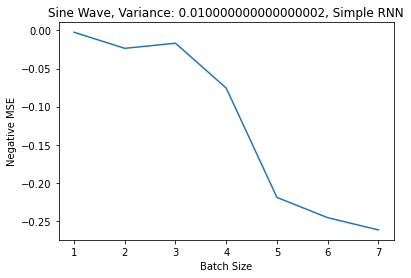

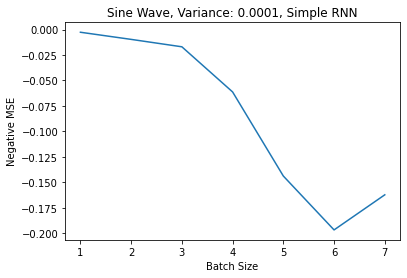

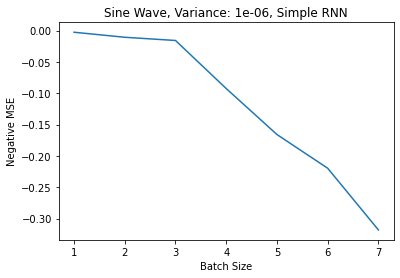

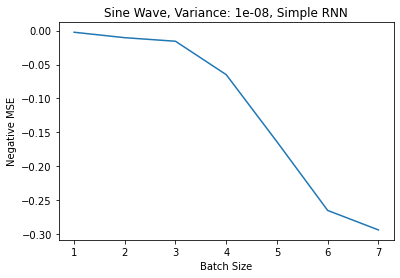

In [13]:
for std in [1, 0.1, 0.01, 0.001, 0.0001]:
  grid_result = process(sine_wave, std = std, Signal_name = 'Sine Wave', verbose = False, LSTM_flag = 0, gridflag = 1)

  plt.figure()
  plt.plot([1, 2, 3, 4, 5, 6, 7], grid_result.cv_results_['mean_test_score'], )
  plt.title('Sine Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Batch Size')
  plt.ylabel('Negative MSE')
  plt.show()

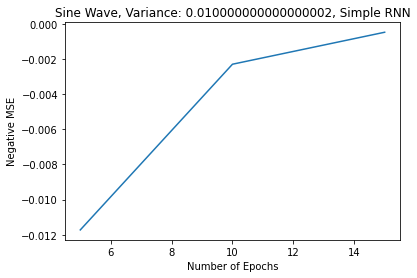

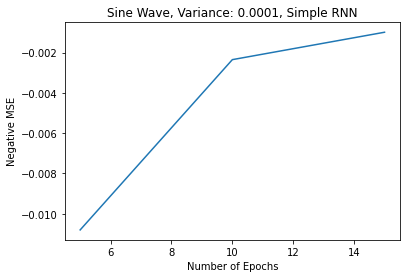

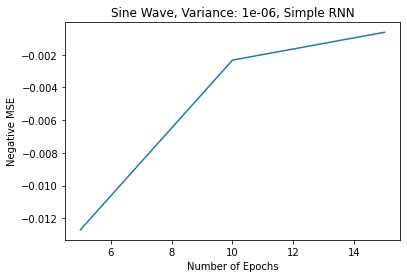

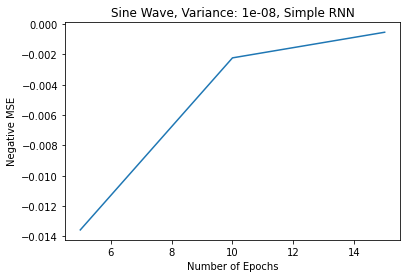

In [6]:
for std in [0.1, 0.01, 0.001, 0.0001]:
  grid_result = process(sine_wave, std = std, Signal_name = 'Sine Wave', verbose = False, LSTM_flag = 0, gridflag = 2)

  plt.figure()
  plt.plot([5, 10, 15], grid_result.cv_results_['mean_test_score'], )
  plt.title('Sine Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Number of Epochs')
  plt.ylabel('Negative MSE')
  plt.show()

Noise Change in time

In [7]:
for std in [0.1, 0.01, 0.001, 0.0001]:
  grid_result = process(sine_wave, std = std, Signal_name = 'Sine Wave', verbose = False, LSTM_flag = 0, gridflag = 0, noise_time = 1)

  plt.figure()
  plt.plot([0.001, 0.01, 0.1], grid_result.cv_results_['mean_test_score'], )
  plt.title('Sine Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Learning Rate')
  plt.ylabel('Negative MSE')
  plt.show()

TypeError: ignored

In [ ]:
for std in [0.1, 0.01, 0.001, 0.0001]:
  grid_result = process(sine_wave, std = std, Signal_name = 'Sine Wave', verbose = False, LSTM_flag = 0, gridflag = 1, noise_time = 1)

  plt.figure()
  plt.plot([1, 3, 5, 7], grid_result.cv_results_['mean_test_score'], )
  plt.title('Sine Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Batch Size')
  plt.ylabel('Negative MSE')
  plt.show()

In [ ]:
for std in [0.1, 0.01, 0.001, 0.0001]:
  grid_result = process(sine_wave, std = std, Signal_name = 'Sine Wave', verbose = False, LSTM_flag = 0, gridflag = 2, noise_time = 1)

  plt.figure()
  plt.plot([5, 10, 15, 20], grid_result.cv_results_['mean_test_score'], )
  plt.title('Sine Wave, Variance: {}, Simple RNN'.format(std**2))
  plt.xlabel('Number of Epochs')
  plt.ylabel('Negative MSE')
  plt.show()